<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    III - Feature Selection
</p>

## Sommaire
1. [Introduction](#1.-Introduction)
2. [Préparation des données](#2.-Préparation-des-données)
3. [Méthode des filtres: élimination par colinéarité](#3.-Méthode-des-filtres:-élimination-par-colinéarité)
4. [Test du Khi-2 pour les variables catégorielles](#4-analyse-de-pertinence)
5. [Recursive Feature Elimination (RFE) avec trois algorithmes]()
    - [5.1. Logistic regression](#5.1-Logistic-Regression)
    - [5.2. Random Forest](#5.2-Random-Forest)
    - [5.3. LightGBM](#5.3-LightGBM)

# 1. Introduction


La sélection des caractéristiques est une étape cruciale pour améliorer les performances des modèles d'apprentissage automatique. Elle permet de réduire  le nombre de variables d'entrée, afin de ne conserver que les plus importantes.

Nous allons utiliser différentes méthodes de sélection de caractéristiques :
- La méthode des filtres pour éliminer les variables redondantes.
- Le test du Khi-2 pour les variables catégorielles indépendantes de la cible.
- La méthode RFE (Recursive Feature Elimination) avec différents algorithmes et choisir celui qui donne la meilleure performance selon le ROC-AUC.

# 2. Préparation des données

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [137]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [138]:
# Chargement des données
app_train = pd.read_csv(f"{folder_path}01_cleaned_app_train.csv")
app_test = pd.read_csv(f"{folder_path}01_cleaned_app_test.csv")

# Exploration rapide
print("Aperçu des données principales :")
display(app_train.head())

Aperçu des données principales :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,nbr_enfants,TARGET,TOTAL_DEBT,DEBT_TO_INCOME_RATIO,PREV_APP_DEBT_RATIO,ANNUITY_TO_CREDIT_RATIO
0,100002,Cash loans,M,N,Y,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,1.0,False,sans_enfant,1,245781.0,1.213733,1.000000,0.060749
1,100003,Cash loans,F,N,N,270000.0,1293502.5,35698.5,1129500.0,Accompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,1.111967,0.027598
2,100004,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,0.828021,0.050000
3,100006,Cash loans,F,N,Y,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,False,sans_enfant,0,0.0,0.000000,1.071609,0.094941
4,100007,Cash loans,M,N,Y,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,1.107012,0.042623


# 3. Méthode des filtres: élimination par colinéarité

Nous allons examiner la corrélation entre les variables indépendantes et éliminer celles qui sont trop corrélées (colinéarité).

Les variables collinéaires sont celles qui sont fortement corrélées entre elles. Elles peuvent réduire la capacité du modèle à apprendre, diminuer l'interprétabilité du modèle et affecter la performance de généralisation sur l'ensemble de test. Clairement, ce sont trois aspects que nous voulons améliorer, donc supprimer les variables collinéaires est une étape utile. Nous établirons un seuil arbitraire pour éliminer les variables collinéaires, puis supprimerons l'une des variables de chaque paire qui dépasse ce seuil.

In [139]:
app_train.dtypes

,0
SK_ID_CURR,int64
NAME_CONTRACT_TYPE,object
CODE_GENDER,object
FLAG_OWN_CAR,object
FLAG_OWN_REALTY,object
...,...
TARGET,int64
TOTAL_DEBT,float64
DEBT_TO_INCOME_RATIO,float64
PREV_APP_DEBT_RATIO,float64


In [140]:
# Calcul de la matrice de corrélation
corr_matrix = app_train.select_dtypes(include=['int64', 'float64']).corr().abs()

In [141]:
corr_matrix[corr_matrix > 0.8]

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,TOTAL_DEBT,DEBT_TO_INCOME_RATIO,PREV_APP_DEBT_RATIO,ANNUITY_TO_CREDIT_RATIO
SK_ID_CURR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_INCOME_TOTAL,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_CREDIT,NaN,NaN,1.000000,NaN,0.986968,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_ANNUITY,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,NaN,NaN,0.986968,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGION_POPULATION_RELATIVE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_BIRTH,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_EMPLOYED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_REGISTRATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_ID_PUBLISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Masque pour ne garder que les paires de variables ayant une corrélation > 0.8
high_corr_var = np.where(corr_matrix > 0.8)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Afficher les variables fortement corrélées
print("Paires de variables corrélées avec un coefficient > 0.8:")
for pair in high_corr_var:
    print(pair)

Paires de variables corrélées avec un coefficient > 0.8:
('AMT_CREDIT', 'AMT_GOODS_PRICE')
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION')
('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI')
('FLOORSMAX_AVG', 'FLOORSMAX_MODE')
('FLOORSMAX_AVG', 'FLOORSMAX_MEDI')
('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI')
('FLOORSMAX_MODE', 'FLOORSMAX_MEDI')
('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE')
('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')
('TOTAL_DEBT', 'DEBT_TO_INCOME_RATIO')


In [143]:
# Suppression des variables fortement corrélées (en laissant la variable la plus corrélée avec le TARGET de chaque paire)
to_drop = []
for pair in high_corr_var:
  if corr_matrix.loc[pair[0], 'TARGET'] > corr_matrix.loc[pair[1], 'TARGET']:
    to_drop.append(pair[1])
  else:
    to_drop.append(pair[0])
app_train = app_train.drop(columns=to_drop)

In [144]:
display(to_drop)

['AMT_CREDIT',
 'REGION_RATING_CLIENT',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVE_CITY_NOT_WORK_CITY',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'TOTAL_DEBT']

In [145]:
# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 60) (48744, 59)


# 4. Test du Khi-2

Nous allons utiliser le test du Khi-2 pour identifier celles qui sont indépendantes de la cible.
Si le p-value du test est supérieur à un seuil (généralement 0.05), nous éliminerons la variable.

In [146]:
x = app_train.drop(columns=['SK_ID_CURR'])
categorical_columns = x.columns

results = []
cols_to_drop = []
alpha = 0.05
for col in categorical_columns:
    contingency_table = pd.crosstab(x['TARGET'], x[col])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    if p > alpha:
        cols_to_drop.append(col)
    results.append(p)

,p_value
TARGET,0.000000e+00
EXT_SOURCE_2,0.000000e+00
EXT_SOURCE_3,0.000000e+00
AMT_GOODS_PRICE,0.000000e+00
REGION_POPULATION_RELATIVE,1.194355e-304
ORGANIZATION_TYPE,5.224541e-299
OCCUPATION_TYPE,3.784500e-288
AMT_ANNUITY,1.694026e-268
NAME_INCOME_TYPE,1.928146e-266
ANNUITY_TO_CREDIT_RATIO,1.572287e-257


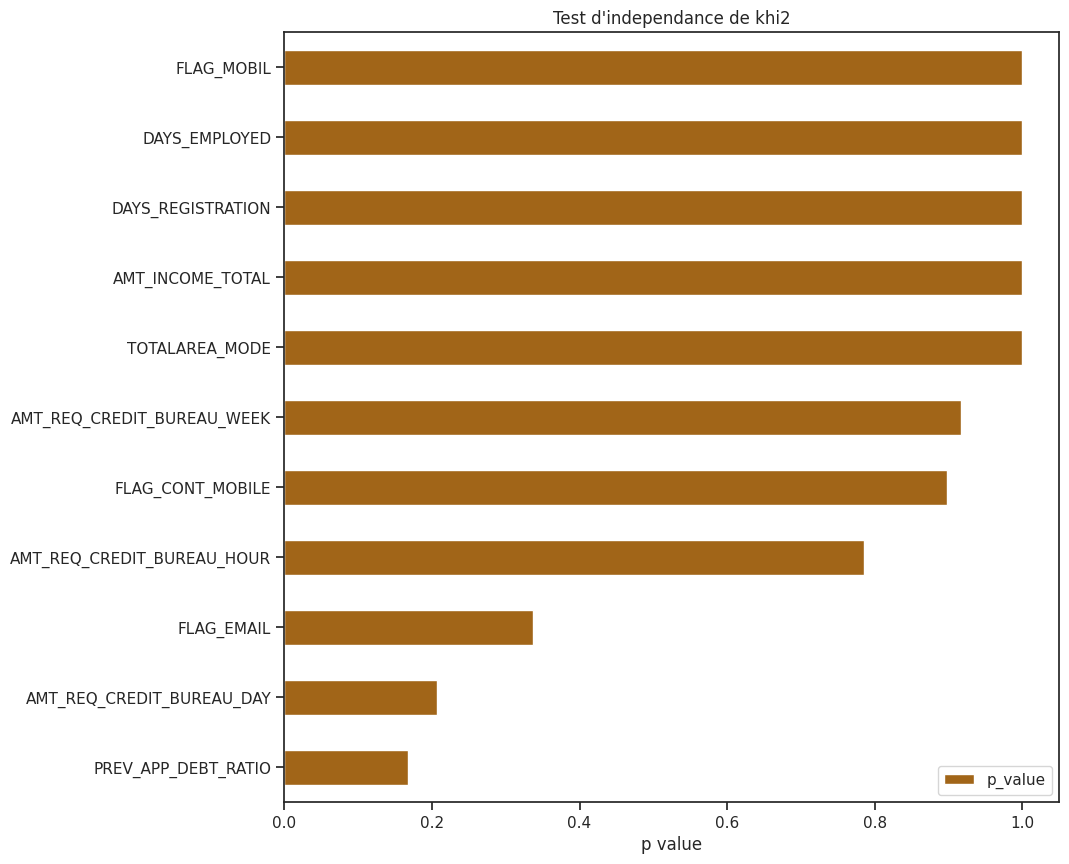

In [147]:
sns.set(style="ticks", rc={'figure.figsize': (10, 10)}, palette="BrBG")

df_pvalue = pd.DataFrame(results, index=categorical_columns, columns=['p_value']).sort_values(by='p_value', ascending=True)

display(df_pvalue)
df_pvalue[df_pvalue['p_value'] > alpha].plot.barh()
plt.xlabel('p value')
plt.title("Test d'independance de khi2")
plt.show()

In [148]:
app_train.drop(labels=cols_to_drop, axis=1, inplace=True)
app_test.drop(labels=cols_to_drop, axis=1, inplace=True)

In [149]:
print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 49) (48744, 48)


# 5. Recursive Feature Elimination (RFE)

Nous allons utiliser RFE pour effectuer une sélection récursive des caractéristiques avec deux algorithmes : Logistic Regression et Random Forest.

Avant de continuer, nous devons nous occuper des variables catégorielles gênantes. Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (sauf pour certains modèles comme LightGBM). Par conséquent, nous devons trouver un moyen de coder (représenter) ces variables sous forme numérique avant de les transmettre au modèle.

In [150]:
# one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Dimension du jeu d'entraînement: ", app_train.shape)
print("Dimension du jeu de test: ", app_test.shape)

Dimension du jeu d'entraînement:  (307511, 158)
Dimension du jeu de test:  (48744, 155)


In [151]:
# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels


print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 156) (48744, 155)


In [152]:
# Séparation du jeu de données en ensembles d'entraînement et de test
X = app_train.copy()

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.dropna()
Y = X['TARGET']

X.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

non_binary_cols = X_train.columns[X_train.nunique() > 2]

# Standardisation des données pour la RFE
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_binary_cols)  # Appliquer seulement sur les colonnes non binaire
    ],
    remainder='passthrough'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

<ipython-input-152-2401d6f5e3ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)


## 5.1 Logistic Regression

In [153]:
%%time
logreg = LogisticRegression(max_iter=100, random_state=42, C=0.1, penalty="l2")
rfe_logreg = RFE(logreg, n_features_to_select=20)
rfe_logreg.fit(X_train_scaled, y_train)

# Evaluation du modèle avec RFE
y_pred_logreg = rfe_logreg.predict_proba(X_test_scaled)[:,1]
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f"ROC AUC pour Logistic Regression avec RFE: {roc_auc_logreg:.4f}")

ROC AUC pour Logistic Regression avec RFE: 0.7236
CPU times: user 3min 5s, sys: 44.2 s, total: 3min 50s
Wall time: 2min 15s


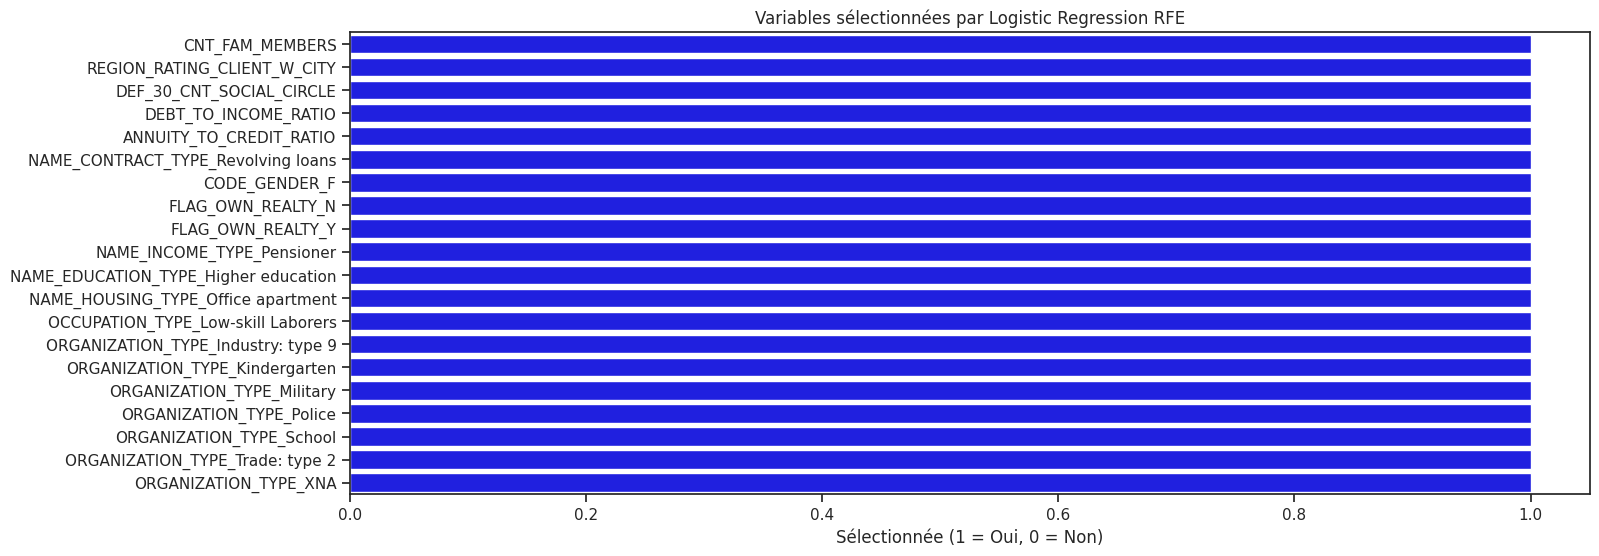

In [154]:

fig = plt.figure(figsize=(16, 6))

sns.barplot(x=rfe_logreg.support_[rfe_logreg.support_].astype(int), y=X_train.columns[rfe_logreg.support_], color='b')
plt.title('Variables sélectionnées par Logistic Regression RFE')
plt.xlabel('Sélectionnée (1 = Oui, 0 = Non)')
plt.ylabel('')

plt.show()

## 5.2 Modèle Random Forest

In [155]:
%%time
rf = RandomForestClassifier(max_depth=10, n_estimators=15, random_state=42, n_jobs=4)
rfe_rf = RFE(rf, n_features_to_select=20)
rfe_rf.fit(X_train, y_train)

# Evaluation du modèle avec RFE
y_pred_rf = rfe_rf.predict_proba(X_test)[:,1]
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"ROC AUC pour Random Forest avec RFE: {roc_auc_rf:.4f}")

ROC AUC pour Random Forest avec RFE: 0.7229
CPU times: user 7min 59s, sys: 2.9 s, total: 8min 2s
Wall time: 4min 54s


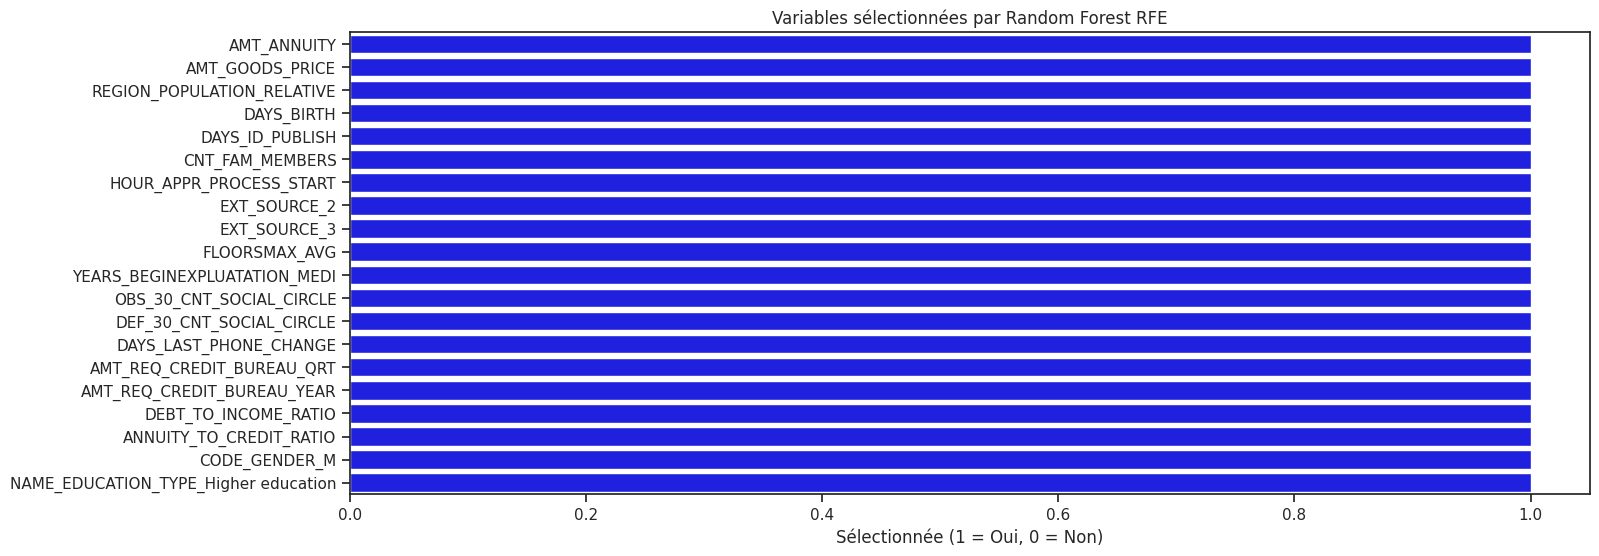

In [156]:
fig = plt.figure(figsize=(16, 6))

sns.barplot(x=rfe_rf.support_[rfe_rf.support_].astype(int), y=X_train.columns[rfe_rf.support_], color='b')
plt.title('Variables sélectionnées par Random Forest RFE')
plt.xlabel('Sélectionnée (1 = Oui, 0 = Non)')
plt.ylabel('')


plt.show()

## 5.3 Modèle LightGBM

In [157]:
%%time
lgbm = LGBMClassifier(max_depth=5, n_estimators=118, random_state=42, n_jobs=-1, verbose=-1)
rfe_lgbm = RFE(lgbm, n_features_to_select=20)
rfe_lgbm.fit(X_train, y_train)

# Evaluation du modèle avec RFE
y_pred_lgbm = rfe_lgbm.predict_proba(X_test)[:,1]
roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
print(f"ROC AUC pour LightGBM avec RFE: {roc_auc_lgbm:.4f}")

ROC AUC pour LightGBM avec RFE: 0.7423
CPU times: user 8min 7s, sys: 4.35 s, total: 8min 11s
Wall time: 5min 1s


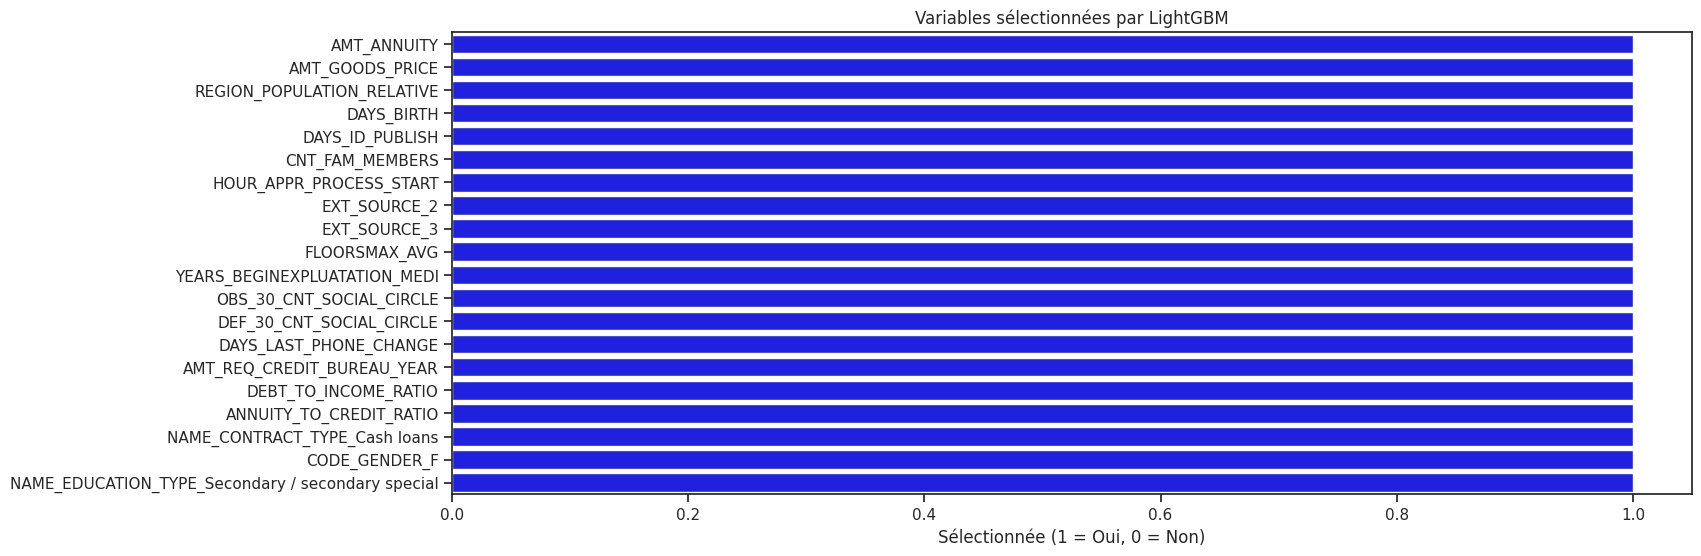

In [159]:
fig = plt.figure(figsize=(16, 6))

sns.barplot(x=rfe_lgbm.support_[rfe_lgbm.support_].astype(int), y=X_train.columns[rfe_lgbm.support_], color='b')
plt.title('Variables sélectionnées par LightGBM')
plt.xlabel('Sélectionnée (1 = Oui, 0 = Non)')
plt.ylabel('')

plt.show()

## Mesure roc_auc

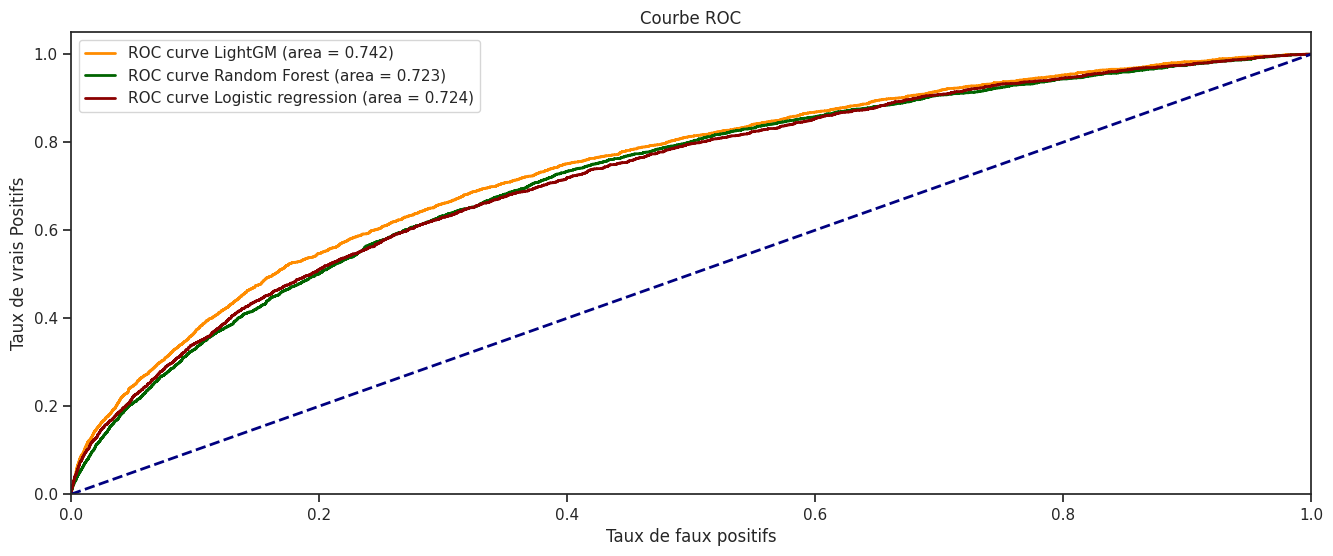

In [160]:
# Calculer des points ROC et l'AUC
fig = plt.figure(figsize=(16, 6))

# Plot LightGM
fpr, tpr, _ = roc_curve(y_test, y_pred_lgbm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve LightGM (area = %0.3f)' % roc_auc)

# Plot Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC curve Random Forest (area = %0.3f)' % roc_auc)

# Plot Logistic regression
fpr, tpr, _ = roc_curve(y_test, y_pred_logreg)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve Logistic regression (area = %0.3f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")

plt.show()

In [161]:
# Sélection du meilleur modèle basé sur ROC AUC
selected_features_logreg = X_train.columns[rfe_logreg.support_]
selected_features_rf = X_train.columns[rfe_rf.support_]
selected_features_lgbm = X_train.columns[rfe_lgbm.support_]

roc_scores = [roc_auc_logreg, roc_auc_rf, roc_auc_lgbm]
models = ['Logistic Regression', 'Random Forest', 'LightGBM']

best_model_index = np.argmax(roc_scores)

print(f"Le meilleur modèle est {models[best_model_index]} avec un ROC AUC de {roc_scores[best_model_index]:.4f}")

Le meilleur modèle est LightGBM avec un ROC AUC de 0.7423


Étant donné que les performances des modèles **Logistic Regression**, **Random Forest** et **LightGBM** sont très proches, respectivement(0.718, 0.722 et 0.744), une approche combinée semble être la plus judicieuse. En effet, chaque modèle peut capturer des aspects différents du problème, et en combinant les caractéristiques sélectionnées par les deux modèles, on peut bénéficier des points forts de chacun. Cette approche permet non seulement de maintenir un nombre raisonnable de caractéristiques, mais aussi de maximiser les informations utiles pour le modèle final. En prenant l'union des caractéristiques sélectionnées par les deux algorithmes, nous espérons améliorer la capacité de prédiction sans introduire un surajout inutile de variables. Nous allons ensuite entraîner un modèle sur ce sous-ensemble de caractéristiques combinées et évaluer ses performances. Cette méthode nous permettra de tester si la combinaison des deux ensembles de caractéristiques améliore effectivement la précision globale du modèle.

In [162]:
combined_features = list(set(selected_features_logreg) | set(selected_features_rf) | set(selected_features_lgbm))
combined_features
print(f"Nombre de feature selectionnées: {len(combined_features)}")

Nombre de feature selectionnées: 37


# 6. Sauvegarde des jeux de données

In [163]:
train_cols = ['SK_ID_CURR']+list(combined_features) + ['TARGET']
test_cols = ['SK_ID_CURR']+list(combined_features)

In [164]:
app_train[train_cols].to_csv(f"{folder_path}final_cleaned_app_train.csv", encoding='utf-8', index=None)
app_test[test_cols].to_csv(f"{folder_path}final_cleaned_app_test.csv", encoding='utf-8', index=None)

In [165]:
print("Dimensions de app_train:", app_train.shape)
print("Dimensions de app_test:", app_test.shape)

Dimensions de app_train: (307511, 156)
Dimensions de app_test: (48744, 155)


# 7. Conclusion

La sélection de caractéristiques permet d'éliminer les variables redondantes ou non pertinentes, ce qui améliore l'efficacité du modèle et réduit le surapprentissage. Les résultats montrent que LightGBM avec RFE est le modèle le plus performant pour cette sélection de caractéristiques. Cependant, étant donné que les scores de  la régression logistique (Logistic Regression)  (0.7184) et de Random Forest (0.722) étaient très proches, nous avons opté pour une approche combinée. Cette approche permet de tirer parti des caractéristiques sélectionnées par les deux modèles, maximisant ainsi les informations utiles tout en évitant le surajout de variables. En combinant les caractéristiques des deux modèles, nous espérons améliorer la capacité prédictive tout en maintenant un modèle plus robuste et mieux équilibré.